In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

# Final model for 180 dataset

In [201]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")
X = X.drop(["max_consecutive_highwind_days", "Densità", "count_highwind", "type_rural", "type_urban"], axis=1)

In [202]:
idx_obs = Y[Y['Count_180'].notna()].index
idx_miss = Y[Y['Count_180'].isna()].index

# take XX% of the remaining indexes for a test set
XX = 0.3 # [0, 1] change this value to change the size of the test set
idx_test = sorted(np.random.choice(idx_obs.values, int(XX*len(idx_obs)), replace=False))
idx_miss = sorted(np.concatenate((idx_test, idx_miss.values)))
idx_obs = sorted(np.setdiff1d(idx_obs, idx_test))

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [203]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [204]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [205]:
model_180 = FetchModel("zip_miss").compile()

In [206]:
data_180 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_180'],
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances,
    "nmonths" : 7,
    "month" : months_obs,
    "month_miss" : months_miss
}

fit_180 = model_180.sample(data=data_180, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_180 = az.from_cmdstanpy(fit_180)

13:12:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:15:50 - cmdstanpy - INFO - CmdStan done processing.
13:15:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip_miss.stan', line 50, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = nan, but A[2,1] = nan (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip_miss.stan', line 50, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip_miss.stan', line 50, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = nan, but A[2,1] = nan (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip_miss.stan', line 50, column 2 to column 63)
Consider re-running with show_console=True if the above output is unclear!


In [207]:
post_pred = PostPred(posterior_180, Y['Count_180'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

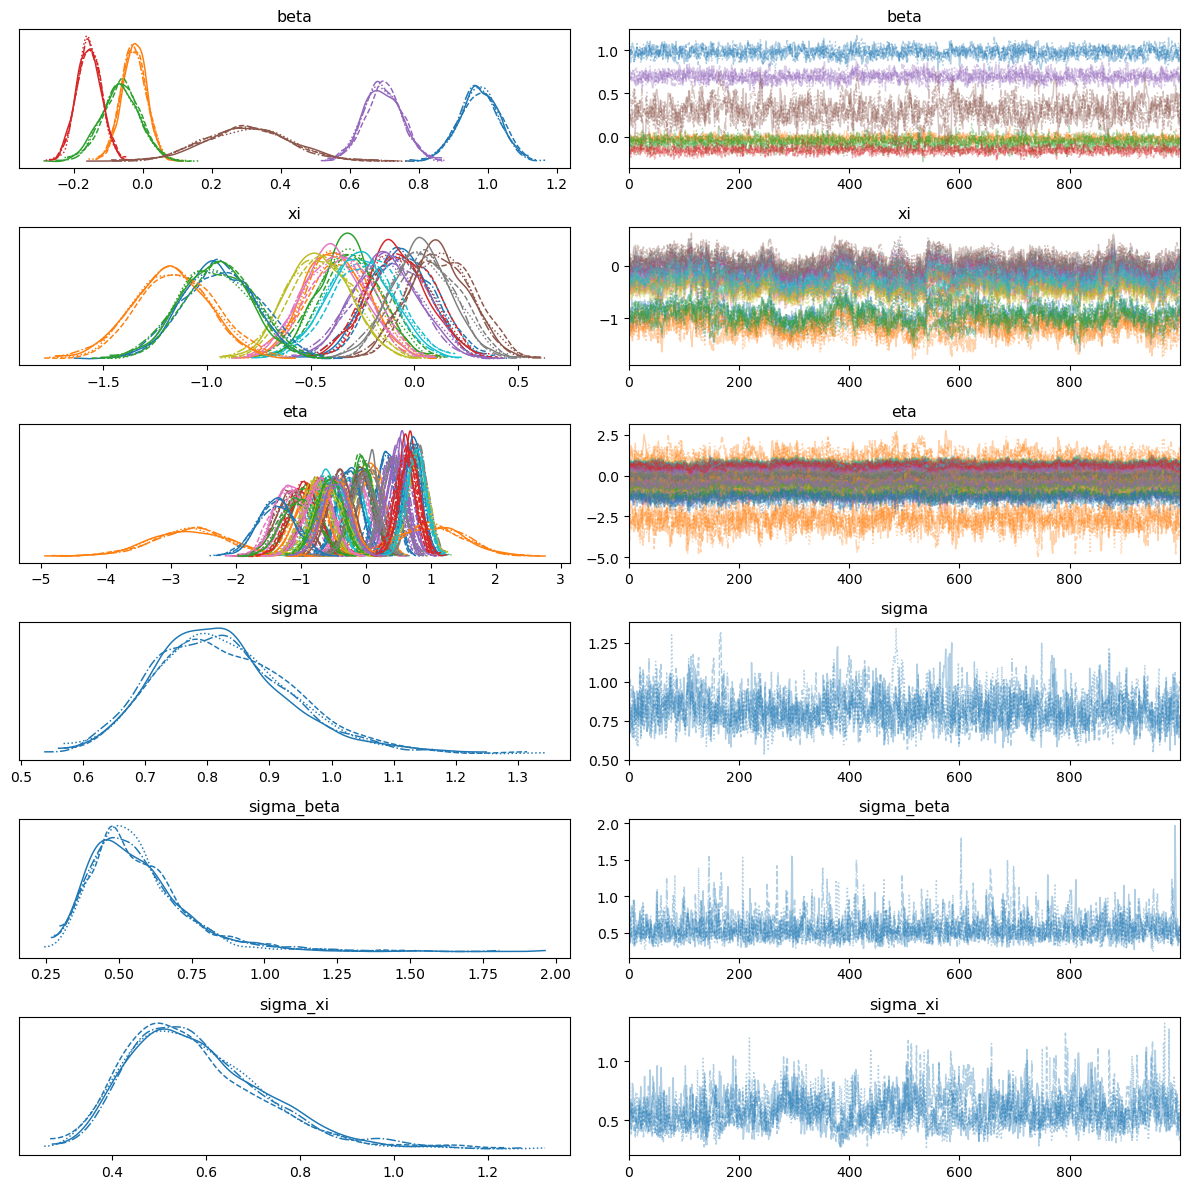

In [208]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_beta', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [209]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2611.69    64.55
p_waic       90.35        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2612.75    64.61
p_loo       91.40        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2661   99.8%
 (0.5, 0.7]   (ok)          5    0.2%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [210]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [211]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE is: {mse_test}\n')
print(f'The MSE is: {mae_test}\n')
print(f'The MSE is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

Outliers:
[  74  150  233  372  384  402  403  441  474  475  579  596  602  656
  676  798  851  872  873 1014 1036 1043 1122 1156 1366 1539 1568 1658
 1748 1813 1832 1878 1973 2110 2127 2224 2240 2338 2389 2440 2449 2518
 2563 2569 2672 2705 2851 2877 2987 2997 3006 3030 3044 3100 3220 3222
 3324 3330 3400 3401 3443 3486 3560 3610 3626 3663 3722 3743]

The total number of outliers is: 68

The total number of outliers in the test set is: 23

The MSE is: 2.2289915966386555

The MAE is: 0.729516806722689

The MAD is: 0.0

The MSE is: 2.224168126094571

The MSE is: 0.7338003502626971

The MSE is: 0.0

The percentage of observations inside the CI is: 0.9821428571428571

The percentage of observations inside the CI of the test is: 0.9798598949211909



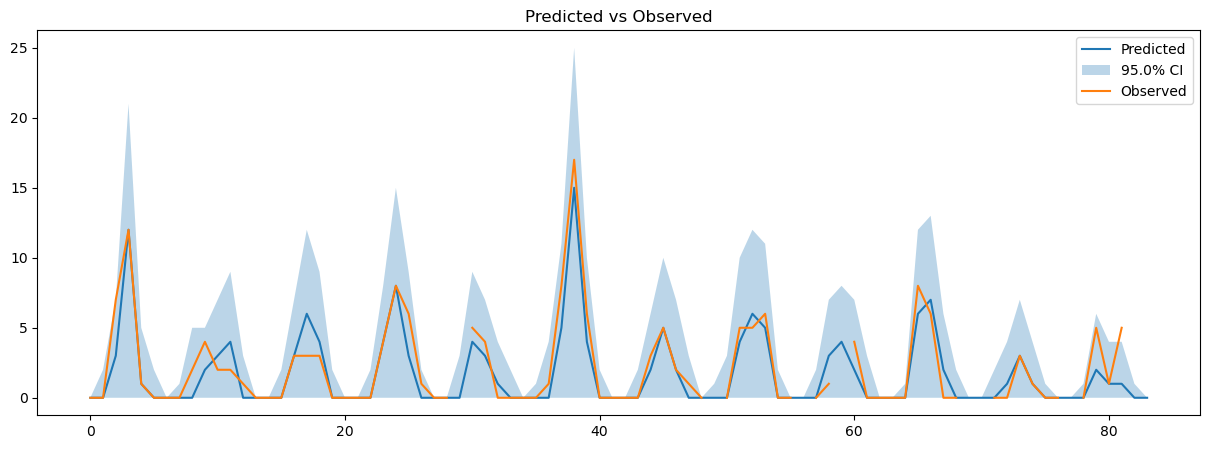

In [212]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [213]:
y_pred, metrics = post_pred.predict(error_metrics=True)

In [214]:
y_pred_temp = post_pred.posterior.y_pred.stack(sample=("chain", "draw"))
y_pred_temp_miss = post_pred.posterior.y_pred_miss.stack(sample=("chain", "draw"))

pred_list_obs = [[] for i in range(0,len(idx_obs))]
idx_temp = np.where(post_pred.posterior.y_pred > 0)
for i in range(0,len(idx_obs)):
    pred_list_obs[i].append(y_pred_temp[i].values[np.where(y_pred_temp[i].values > 0)])

pred_list_miss = [[] for i in range(0,len(idx_miss))]
idx_temp = np.where(post_pred.posterior.y_pred_miss > 0)
for i in range(0,len(idx_miss)):
    pred_list_miss[i].append(y_pred_temp_miss[i].values[np.where(y_pred_temp_miss[i].values > 0)]) #Non manca un miss?

pred_list_obs = pd.Series(pred_list_obs, index=idx_obs)
pred_list_miss = pd.Series(pred_list_miss, index=idx_miss)

pred_list = pd.concat([pred_list_obs, pred_list_miss]).sort_index()

pred_list_obs = pred_list_obs.reset_index(drop=True)
pred_list_miss = pred_list_miss.reset_index(drop=True)

In [215]:
alpha = 0.05
theta_med = post_pred.posterior_med.theta.values
alpha_adj = (alpha+theta_med-alpha*theta_med)
y_star_low_obs = []
y_star_up_obs = []
for k in range(0, len(idx_obs)):
    if len(pred_list_obs[k][0]) == 0:
        y_star_low_obs.append(0)
        y_star_up_obs.append(0)
    else:
        y_star_low_obs.append(np.quantile(pred_list_obs[k][0], alpha_adj[months_obs[k]-1]/2))
        y_star_up_obs.append(np.quantile(pred_list_obs[k][0], 1-alpha_adj[months_obs[k]-1]/2))

y_star_low_miss = []
y_star_up_miss = []
for k in range(0, len(idx_miss)):
    if len(pred_list_miss[k][0]) == 0:
        y_star_low_miss.append(0)
        y_star_up_miss.append(0)
    else:
        y_star_low_miss.append(np.quantile(pred_list_miss[k][0], alpha_adj[months_miss[k]-1]/2))
        y_star_up_miss.append(np.quantile(pred_list_miss[k][0], 1-alpha_adj[months_miss[k]-1]/2))

y_star_up_obs = pd.Series(y_star_up_obs, index=idx_obs)
y_star_low_obs = pd.Series(y_star_low_obs, index=idx_obs)
y_star_up_miss = pd.Series(y_star_up_miss, index=idx_miss)
y_star_low_miss = pd.Series(y_star_low_miss, index=idx_miss)

y_star_up = pd.concat([y_star_up_obs, y_star_up_miss]).sort_index()
y_star_low = pd.concat([y_star_low_obs, y_star_low_miss]).sort_index()

y_star_up_obs = y_star_up_obs.reset_index(drop=True)
y_star_low_obs = y_star_low_obs.reset_index(drop=True)
y_star_up_miss = y_star_up_miss.reset_index(drop=True)  
y_star_low_miss = y_star_low_miss.reset_index(drop=True)


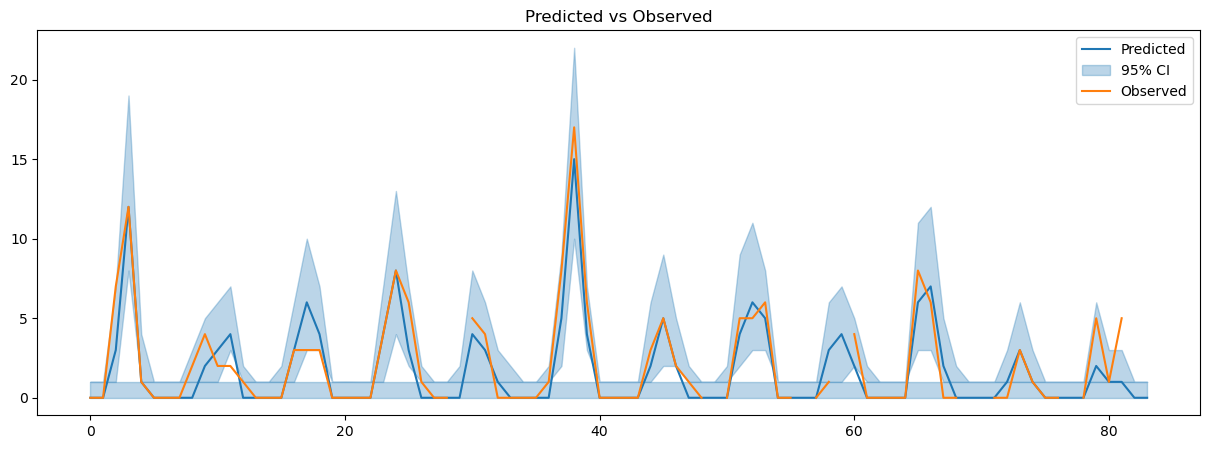

In [216]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', color = 'C0')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], color = 'C0', alpha=0.3, label=f'95% CI')
plt.fill_between(xx, np.zeros(len(xx)), np.zeros(len(xx))+1,color = 'C0', alpha=0.3)
plt.plot(xx, Y_data[xx], label='Observed', color = 'C1')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [217]:
idx_obs_test = sorted(np.concatenate((idx_obs, idx_test)))
outliers = np.where(((Y['Count_180'][idx_obs_test] < y_star_low[idx_obs_test]) | (Y['Count_180'][idx_obs_test] > y_star_up[idx_obs_test])) & Y['Count_180'][idx_obs_test]!=0)[0]
percentage_inside_CI = 1-len(outliers)/len(idx_obs_test)

In [218]:
outliers_test = np.where(((Y['Count_180'][idx_test] < y_star_low[idx_test]) | (Y['Count_180'][idx_test] > y_star_up[idx_test])) & Y['Count_180'][idx_test]!=0)[0]
percentage_inside_CI_test = 1-len(outliers_test)/len(idx_test)

In [219]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE is: {mse_test}\n')
print(f'The MSE is: {mae_test}\n')
print(f'The MSE is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside_CI}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

Outliers:
[  11   74   78   94  112  150  155  193  233  280  345  346  364  365
  366  372  378  384  402  403  441  474  475  529  579  602  619  630
  644  650  656  657  658  675  676  677  698  710  729  798  851  862
  867  872  873  875 1014 1036 1043 1092 1093 1122 1135 1142 1156 1157
 1173 1262 1279 1353 1366 1380 1393 1447 1448 1455 1524 1529 1531 1539
 1557 1560 1568 1580 1582 1588 1618 1632 1647 1658 1702 1748 1807 1813
 1821 1832 1878 1879 1923 1928 1935 1973 1983 2095 2102 2110 2127 2135
 2139 2179 2224 2240 2330 2331 2338 2350 2357 2371 2377 2389 2440 2445
 2458 2479 2512 2518 2532 2561 2562 2569 2588 2601 2602 2634 2646 2649
 2650 2672 2680 2693 2705 2750 2757 2769 2823 2851 2877 2879 2905 2940
 2987 2998 2999 3001 3006 3007 3018 3030 3044 3087 3100 3160 3185 3220
 3222 3227 3322 3330 3346 3355 3361 3392 3401 3443 3486 3507 3560 3610
 3611 3613 3626 3663 3683 3688 3693 3700 3723 3743 3770]

The total number of outliers is: 179

The total number of outliers in the test s

# Final model for 120 dataset

In [ ]:
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y['Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")

In [ ]:
idx_obs = Y[Y['Count_120'].notna()].index
idx_miss = Y[Y['Count_120'].isna()].index

# take XX% of the remaining indexes for a test set
XX = 0.3 # [0, 1] change this value to change the size of the test set
idx_test = sorted(np.random.choice(idx_obs.values, int(XX*len(idx_obs)), replace=False))
idx_miss = sorted(np.concatenate((idx_test, idx_miss.values)))
idx_obs = sorted(np.setdiff1d(idx_obs, idx_test))

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [ ]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [ ]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [ ]:
months_to_repeat = [7]
dummy_july = np.zeros(X.shape[0])
idx_july = np.where(Y['Month'].isin(months_to_repeat))[0]
dummy_july[idx_july] = 1
dummy_july_obs = pd.Series(dummy_july[idx_obs])
dummy_july_miss = pd.Series(dummy_july[idx_miss])


In [ ]:
model_120 = FetchModel("space_dummy_rej").compile()

In [ ]:
data_120 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_july_obs,
    "dummy_miss": dummy_july_miss
}

fit_120 = model_120.sample(data=data_120, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_120 = az.from_cmdstanpy(fit_120)

16:22:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:30:45 - cmdstanpy - INFO - CmdStan done processing.
16:30:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy_rej.stan', line 58, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy_rej.stan', line 58, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'space_dummy_rej.stan', line 58, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy_rej.stan', line 58, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy_rej.stan', line 58, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy_rej.stan', line 58, column 2 to column 63)
	Exception: cholesky_decompose: A is not 

In [ ]:
post_pred = PostPred(posterior_120, Y['Count_120'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

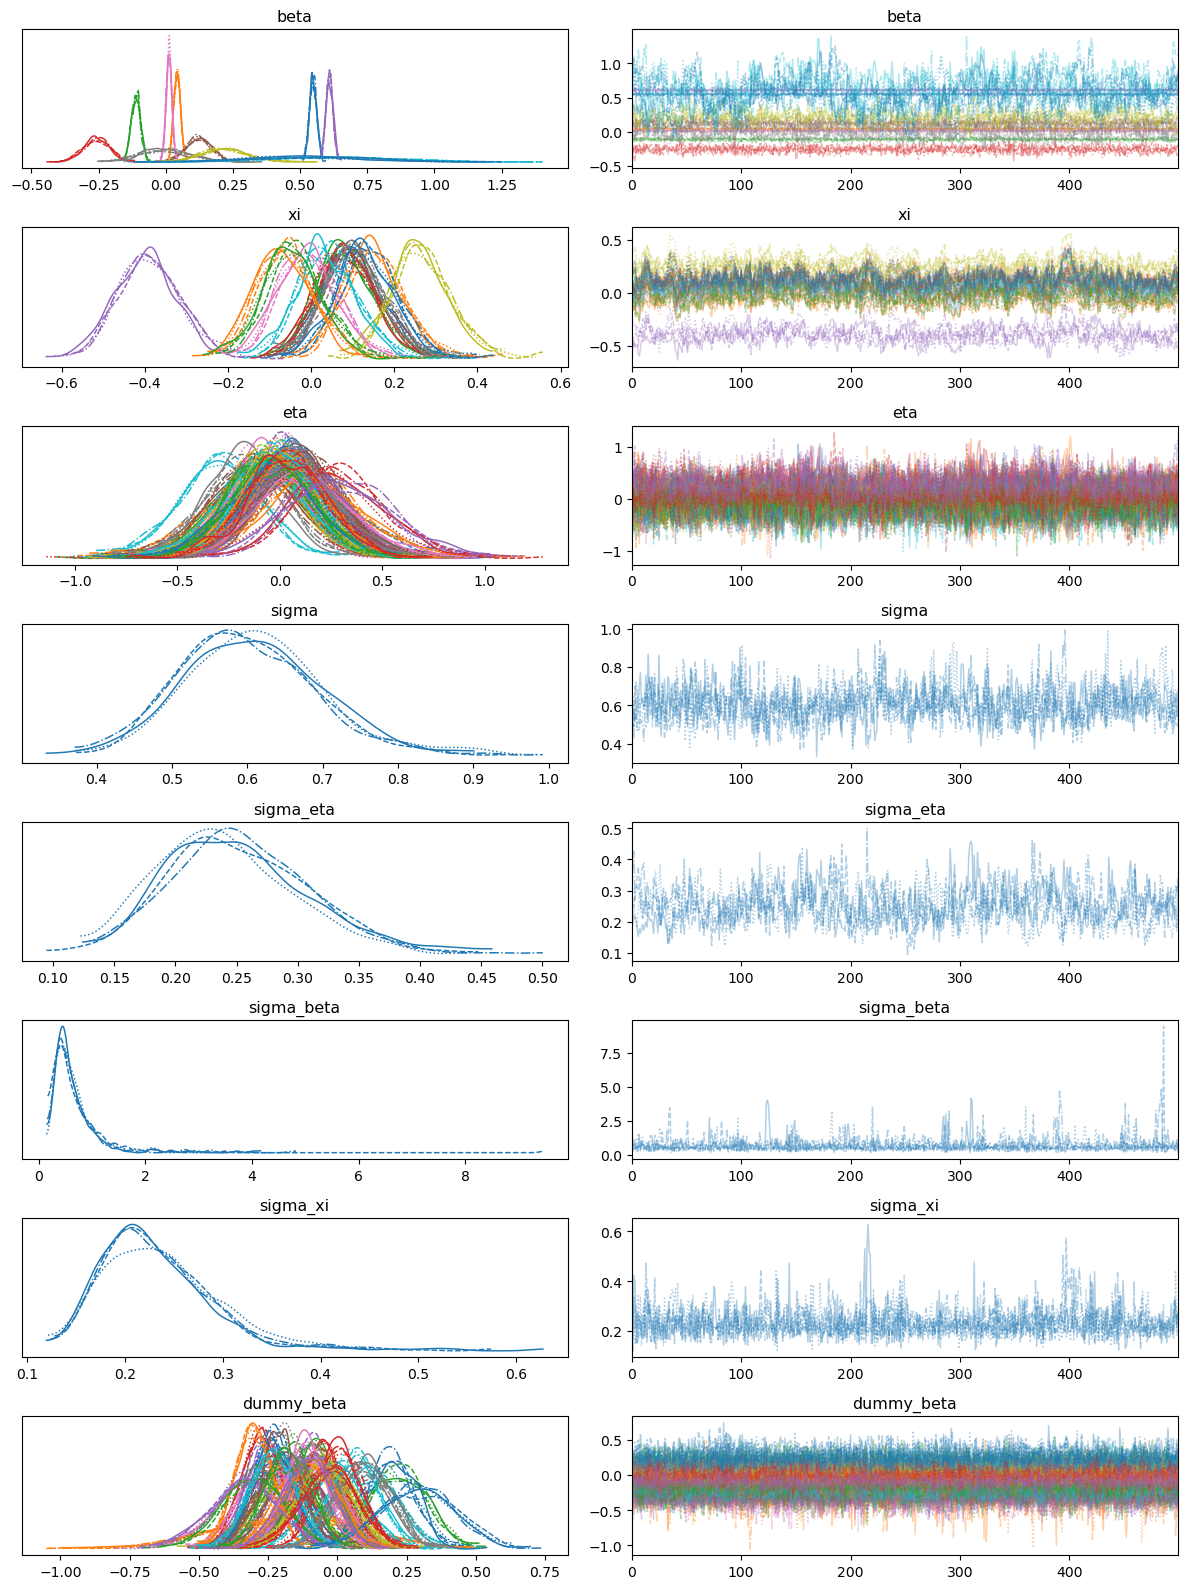

In [ ]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma',  'sigma_beta', 'sigma_xi', 'sigma_dummy', 'gamma'])
plt.tight_layout()
plt.show()

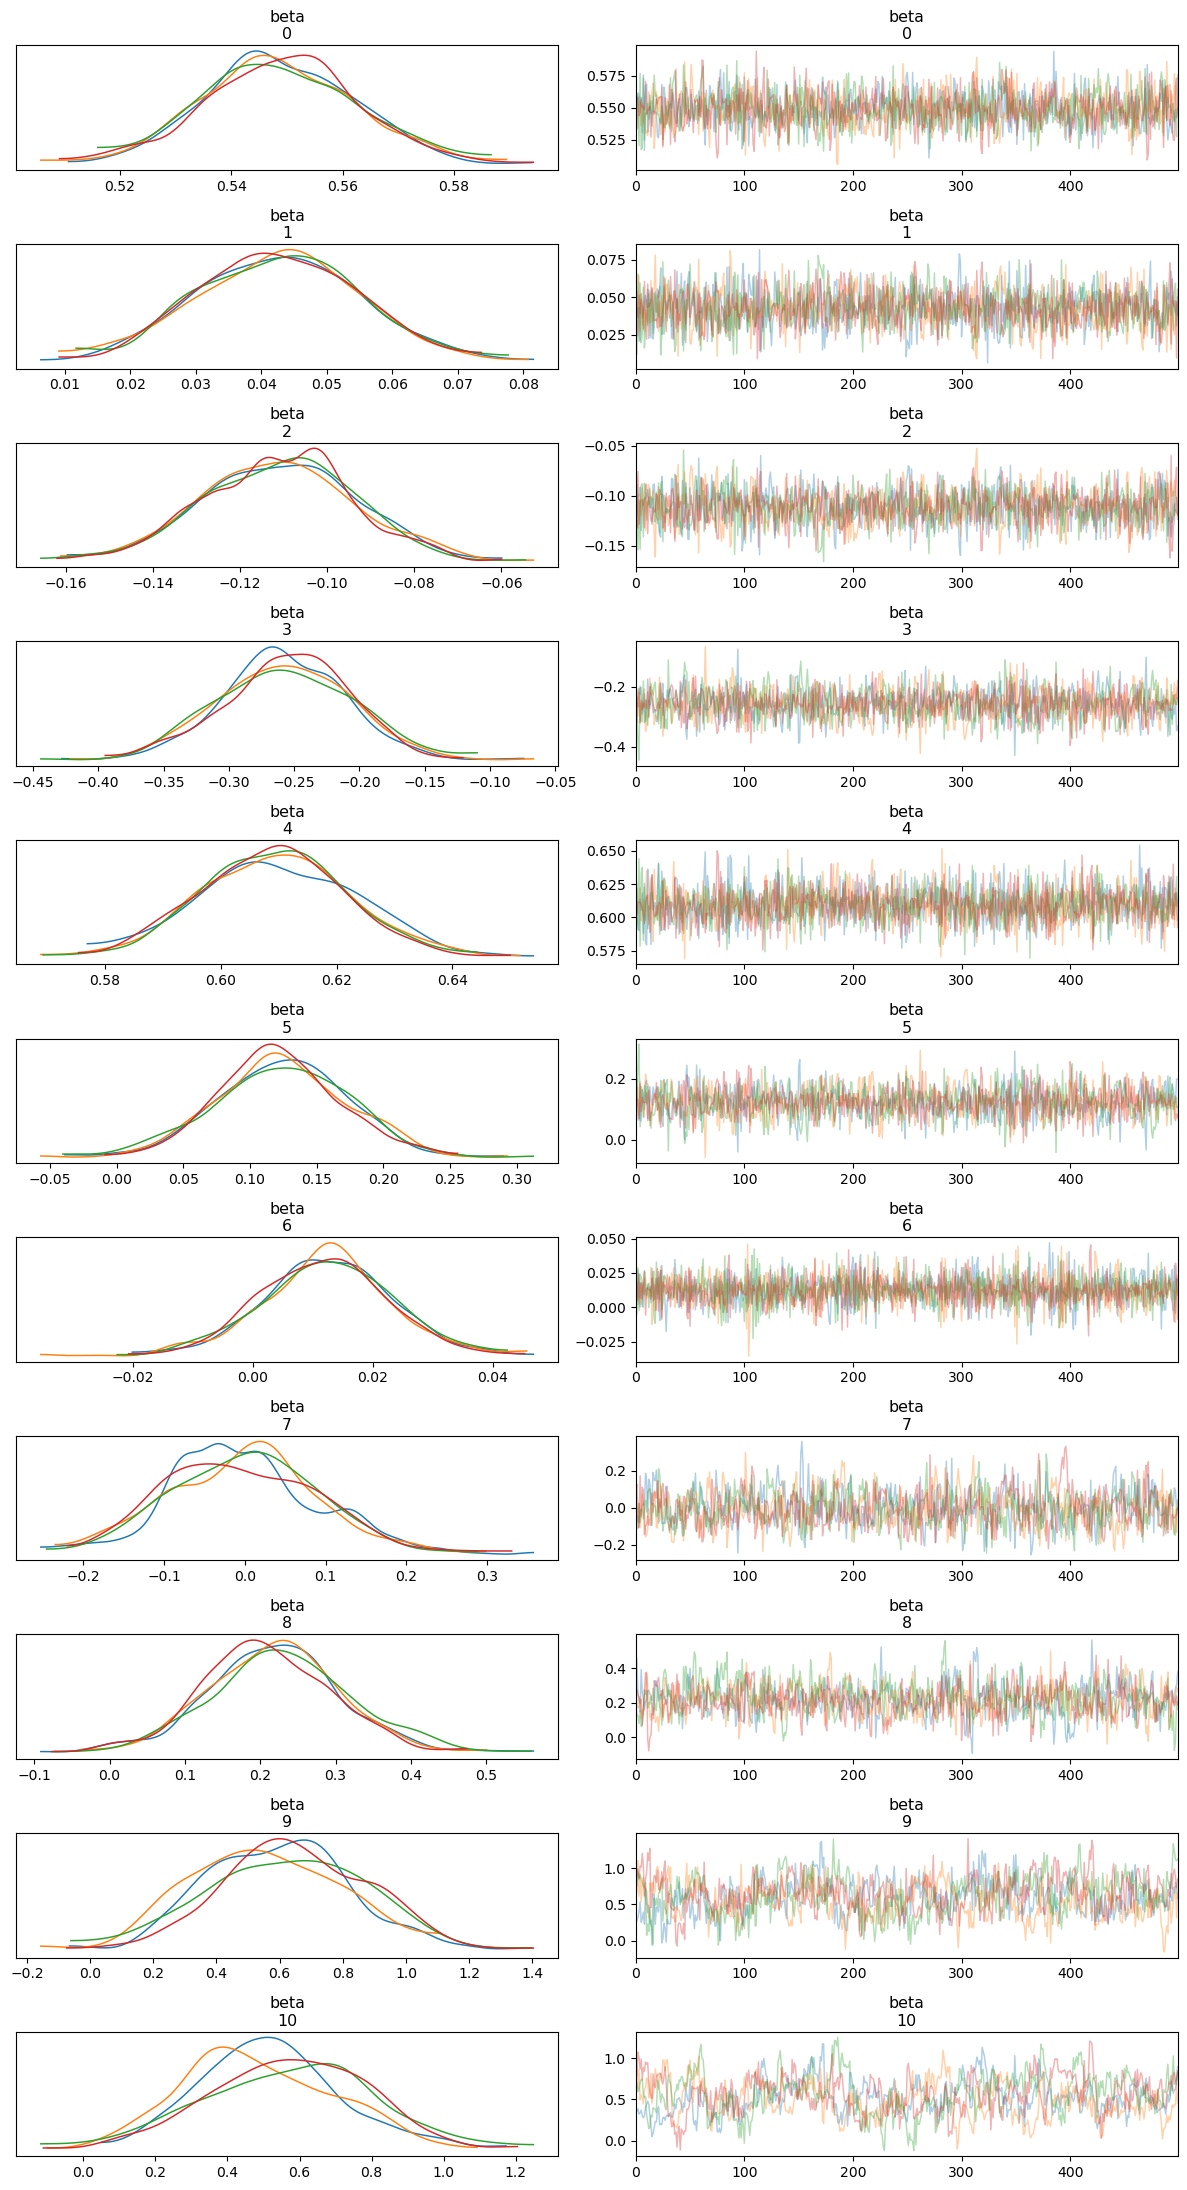

In [ ]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 2688 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -7044.13    72.32
p_waic      154.43        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 2688 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -7045.72    72.37
p_loo      156.02        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2680   99.7%
 (0.5, 0.7]   (ok)          7    0.3%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [ ]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [ ]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE is: {mse_test}\n')
print(f'The MSE is: {mae_test}\n')
print(f'The MSE is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

Outliers:
[  21   34   83  145  165  173  227  234  309  350  351  362  363  385
  391  394  396  404  410  413  414  420  422  429  430  433  472  477
  478  479  481  482  486  488  493  512  519  557  581  582  584  585
  588  599  609  618  650  662  665  669  682  685  689  690  695  701
  718  753  757  760  769  770  771  774  775  781  799  802  807  835
  842  863  864  869  874  876  877  884  898  901  917  919  920  921
  950  955  962  970  984  985 1016 1019 1021 1022 1026 1036 1042 1043
 1053 1073 1105 1118 1146 1158 1165 1179 1185 1195 1222 1283 1329 1331
 1341 1371 1384 1385 1407 1408 1449 1457 1527 1535 1539 1540 1552 1553
 1559 1563 1611 1631 1639 1647 1765 1774 1786 1824 1859 1867 1869 1874
 1889 1897 1903 1911 1912 1953 1955 1960 1978 1983 1989 2008 2026 2029
 2050 2075 2076 2109 2110 2115 2119 2127 2134 2137 2144 2180 2214 2221
 2227 2228 2233 2234 2238 2250 2251 2291 2301 2315 2327 2332 2363 2367
 2375 2382 2398 2399 2406 2430 2458 2460 2462 2464 2465 2495 2503 2

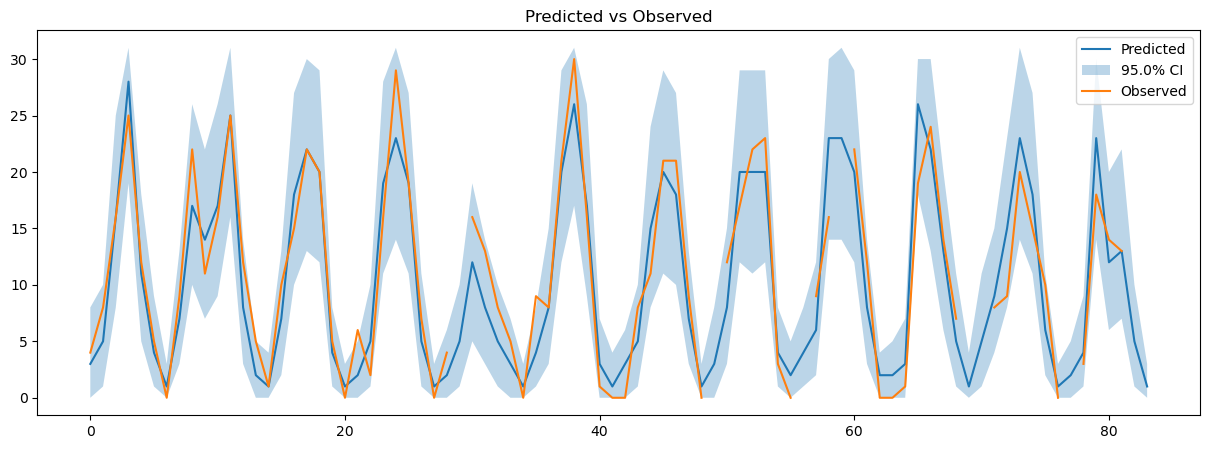

In [ ]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()